In [1]:
import numpy as np
import os
import pysynphot as s
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/pysynphot/locations.py:44: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/lib/python2.7/dist-packages/pysynphot/locations.py:119: UserWarning: Extinction files should be moved to $PYSYN_CDBS/extinction for compatibility with future versions of pysynphot.
  warnings.warn('Extinction files should be moved to '
/usr/local/lib/python2.7/dist-packages/pysynphot/locations.py:155: UserWarning: Extinction files not found in grid/extinction
  warnings.warn('Extinction files not found in %s' % (extdir,))
/usr/local/lib/python2.7/dist-packages/pysynphot/locations.py:133: UserWarning: PYSYN_CDBS is undefined; cannot find mtab/*_tmg.fits file
  warnings.warn("PYSYN_CDBS is undefined; cannot find %s file" % template)
/usr/local/lib/python2.7/dist-packages/pysynphot/locations.py:133: UserWarning: PYSYN_CDBS is undefined; cannot find mtab/*_tmc.fi

In [2]:
results_path       = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check/Results'
jpas_filters_path  = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Filters/JPAS_filters'
test_specs         = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check/Specs'
jpas_filters_list  = np.loadtxt('/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Filters/jpas_filters_list.txt', dtype=str)
specs_list         = np.loadtxt('/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check/specslist2.txt', dtype=str)

In [3]:
# Constants --------------------------------------------------------------------------------------------------------
c = 2.99792458E18                  # Light Speed in Angstrom s^-1

In [4]:
# Setting the T80 M1 effective area in cm^2 ------------------------------------------------------------------------
s.setref(area=4400)

In [5]:
%matplotlib inline

0443.51873.152_nozeroes.txt


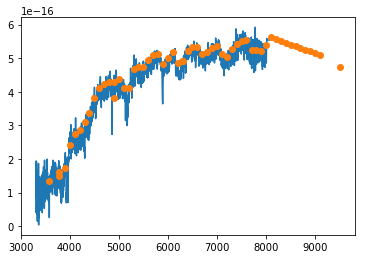

1019.52707.261.txt


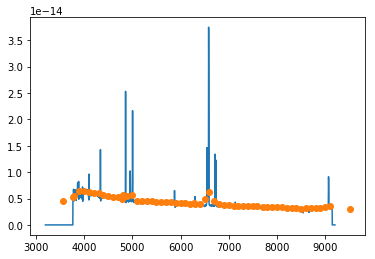

1180.52995.637.txt
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained

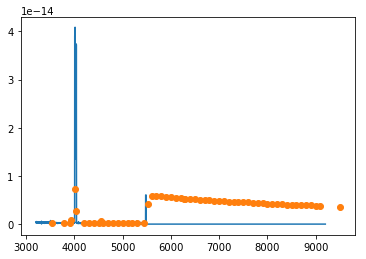

1665.52976.514_nozeroes.txt


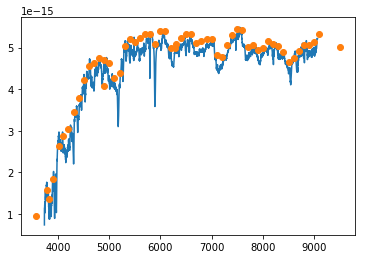

2231.53816.545.txt


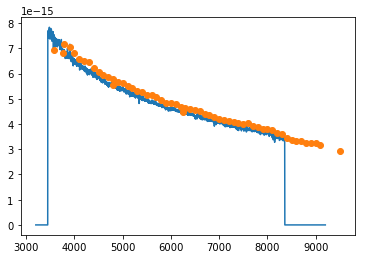

In [10]:
# JPAS -------------------------------------------------------------------------------------------------------------
all_jpas = []
for each_spectrum in specs_list:
    # Transforming the specs from f_lambda to f_nu -----------------------------------------------------------------
    wavelength = np.loadtxt(os.path.join(test_specs, each_spectrum), usecols=[0])
    f_lambda   = np.loadtxt(os.path.join(test_specs, each_spectrum), usecols=[1])
    
    # Simulating the photometry for each J-PAS band ----------------------------------------------------------------
    print each_spectrum
    filter_name     = []
    photometry      = []
    photometry_flam = []
    lambda_eff      = []
    for jpas_filters in jpas_filters_list:
        filter_name_i          = jpas_filters.split('.')[0]
        filter_name.append(filter_name_i)
        jpas_filter_bandpass = s.FileBandpass(os.path.join(jpas_filters_path, jpas_filters))      
        sdss_spectrum = s.FileSpectrum(os.path.join(test_specs, each_spectrum))
        
        # Correcting for the effects of flux = 0: ----------------------------------------------------------------------
        index = np.where(sdss_spectrum.flux > 0)
        sdss_spectrum2 = s.ArraySpectrum(wave=sdss_spectrum.wave[index], flux=sdss_spectrum.flux[index], 
                                         fluxunits=sdss_spectrum.fluxunits, waveunits=sdss_spectrum.waveunits)
        
        # Adapting the binset for each spectrum --------------------------------------------------------------------
        binset = np.arange(sdss_spectrum2.wave.min().round(), sdss_spectrum2.wave.max().round())
        
        # Calculating the simulated photometry ---------------------------------------------------------------------
        photometry_i = s.Observation(sdss_spectrum2, jpas_filter_bandpass, binset=jpas_filter_bandpass.wave, 
                                     force='extrap')
        photometry.append(photometry_i.effstim('abmag'))
        photometry_flam_i = photometry_i.effstim('flam')
        photometry_flam.append(photometry_flam_i)
        
        # Calculating the effective wavelength ---------------------------------------------------------------------
        lambda_eff_i = photometry_i.efflam()
        lambda_eff.append(lambda_eff_i)

    # Transforming everything into an array ------------------------------------------------------------------------
    filter_name       = np.array(filter_name)
    photometry        = np.array(photometry)
    lambda_eff        = np.array(lambda_eff) 
    photometry_flam   = np.array(photometry_flam)
    photometry_fnu    = 10**(-0.4*(photometry + 48.60))
    
#     numerator_sum   = 0
#     denominator_sum = 0
#     ratio = []
#     for j in range(lambda_eff.size):
#         index = np.abs(lambda_eff[j] - wavelength).argmin()
#         numerator_sum   = numerator_sum + (photometry_flam[j] * f_lambda[index])
#         denominator_sum = denominator_sum + (photometry_flam[j] ** 2.)
#         correction_factor = (numerator_sum / denominator_sum)
#         ratio_i = photometry_flam[j]/f_lambda[index]
#         ratio.append(ratio_i)
#     photometry_flam = photometry_flam * correction_factor
    
    plot01 = plt.plot(wavelength, f_lambda, '-')
    plot02 = plt.plot(lambda_eff, photometry_flam, 'o')
    plt.savefig(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS.png'), dpi = 100)
    plt.show()
    
#     galaxy_simulation_abmag = np.vstack((filter_name, photometry))
#     galaxy_simulation_abmag = pd.DataFrame(galaxy_simulation_abmag)
#     galaxy_simulation_abmag.to_csv(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS_abmag.csv'), 
#                                    sep=',', header=None, index=False)
#     galaxy_simulation_fnu = np.vstack((filter_name, photometry_fnu))
#     galaxy_simulation_fnu = pd.DataFrame(galaxy_simulation_fnu)
#     galaxy_simulation_fnu.to_csv(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS_fnu.csv'), 
#                                  sep=',', header=None, index=False)

    


0443.51873.152_nozeroes.txt


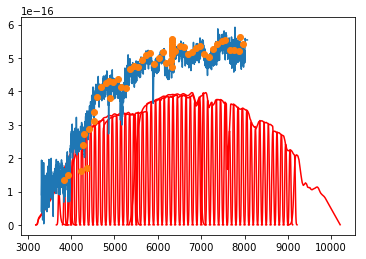

1019.52707.261.txt


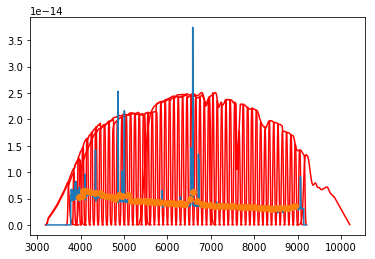

1180.52995.637.txt
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained

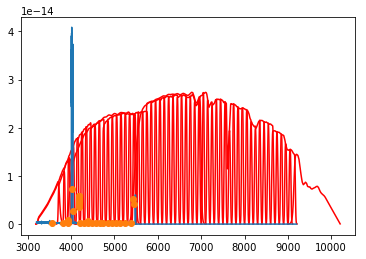

1665.52976.514_nozeroes.txt


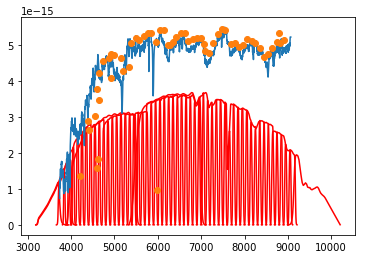

2231.53816.545.txt


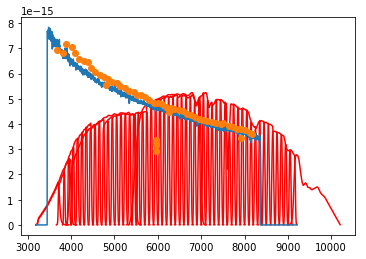

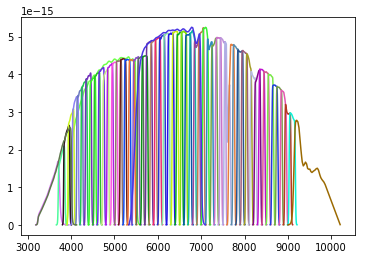

In [9]:
# JPAS -------------------------------------------------------------------------------------------------------------
all_jpas = []
for each_spectrum in specs_list:
    # Transforming the specs from f_lambda to f_nu -----------------------------------------------------------------
    wavelength = np.loadtxt(os.path.join(test_specs, each_spectrum), usecols=[0])
    f_lambda   = np.loadtxt(os.path.join(test_specs, each_spectrum), usecols=[1])
    
    # Simulating the photometry for each J-PAS band ----------------------------------------------------------------
    print each_spectrum
    filter_name     = []
    photometry      = []
    photometry_flam = []
    lambda_eff      = []
    for jpas_filters in jpas_filters_list:
        filter_name_i          = jpas_filters.split('.')[0]
        filter_name.append(filter_name_i)
        jpas_filter_bandpass = s.FileBandpass(os.path.join(jpas_filters_path, jpas_filters))      
        sdss_spectrum = s.FileSpectrum(os.path.join(test_specs, each_spectrum))
        
        # Correcting for the effects of flux = 0: ----------------------------------------------------------------------
        index = np.where(sdss_spectrum.flux > 0)
        sdss_spectrum2 = s.ArraySpectrum(wave=sdss_spectrum.wave[index], flux=sdss_spectrum.flux[index], 
                                         fluxunits=sdss_spectrum.fluxunits, waveunits=sdss_spectrum.waveunits)
        
        # Adapting the binset for each spectrum --------------------------------------------------------------------
        binset = np.arange(sdss_spectrum2.wave.min().round(), sdss_spectrum2.wave.max().round())
        
        # Calculating the simulated photometry ---------------------------------------------------------------------
        photometry_i = s.Observation(sdss_spectrum2, jpas_filter_bandpass, binset=binset, 
                                     force='extrap')
        photometry.append(photometry_i.effstim('abmag'))
        photometry_flam_i = photometry_i.effstim('flam')
        photometry_flam.append(photometry_flam_i)
        
        # Calculating the effective wavelength ---------------------------------------------------------------------
        lambda_eff_i = photometry_i.efflam()
        lambda_eff.append(lambda_eff_i)

        # Setting the filters throughput ---------------------------------------------------------------------------
        fmax = sdss_spectrum.flux.max()
        plt.plot(jpas_filter_bandpass.wave, jpas_filter_bandpass.throughput * fmax, label='%s' % each_spectrum, 
                 color='red')

    # Transforming everything into an array ------------------------------------------------------------------------
    filter_name       = np.array(filter_name)
    photometry        = np.array(photometry)
    lambda_eff        = np.array(lambda_eff) 
    photometry_flam   = np.array(photometry_flam)
    photometry_fnu    = 10**(-0.4*(photometry + 48.60))
    
#     numerator_sum   = 0
#     denominator_sum = 0
#     ratio = []
#     for j in range(lambda_eff.size):
#         index = np.abs(lambda_eff[j] - wavelength).argmin()
#         numerator_sum   = numerator_sum + (photometry_flam[j] * f_lambda[index])
#         denominator_sum = denominator_sum + (photometry_flam[j] ** 2.)
#         correction_factor = (numerator_sum / denominator_sum)
#         ratio_i = photometry_flam[j]/f_lambda[index]
#         ratio.append(ratio_i)
#     photometry_flam = photometry_flam * correction_factor
    
    plot01 = plt.plot(wavelength, f_lambda, '-')
    plot02 = plt.plot(lambda_eff, photometry_flam, 'o')
    plt.savefig(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS.png'), dpi = 100)
    plt.show()
    
#     galaxy_simulation_abmag = np.vstack((filter_name, photometry))
#     galaxy_simulation_abmag = pd.DataFrame(galaxy_simulation_abmag)
#     galaxy_simulation_abmag.to_csv(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS_abmag.csv'), 
#                                    sep=',', header=None, index=False)
#     galaxy_simulation_fnu = np.vstack((filter_name, photometry_fnu))
#     galaxy_simulation_fnu = pd.DataFrame(galaxy_simulation_fnu)
#     galaxy_simulation_fnu.to_csv(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS_fnu.csv'), 
#                                  sep=',', header=None, index=False)


filter_name = []
for jpas_filters in jpas_filters_list:
    filter_name_i          = jpas_filters.split('.')[0]
    filter_name.append(filter_name_i)
    jpas_filter_bandpass = s.FileBandpass(os.path.join(jpas_filters_path, jpas_filters))
    plt.plot(jpas_filter_bandpass.wave, jpas_filter_bandpass.throughput * fmax, label='%s' % each_spectrum, 
                 color=np.random.rand(3,1))
plt.show()
    


0443.51873.152_nozeroes.txt
('g_JPAS_0915', 0.87460795752808784)
('Jv0915_3495', 1.5375881139108425)
('Jv0915_3781', 0.59979697711267388)
('Jv0915_3900', 0.52208042457564252)
('Jv0915_4000', 0.88733283709119293)
('Jv0915_4100', 1.085462205279728)
('Jv0915_4200', 0.8788659148323249)
('Jv0915_4301', 0.79966526952859385)
('Jv0915_4400', 1.0035664653711101)
('Jv0915_4501', 0.99877247933761504)
('Jv0915_4600', 1.0373354427271801)
('Jv0915_4701', 0.95784616125214717)
('Jv0915_4801', 1.1027992139321301)
('Jv0915_4900', 0.98524596744546844)
('Jv0915_5001', 1.0804622247395939)
('Jv0915_5101', 1.0635323618533969)
('Jv0915_5201', 1.0339187096794891)
('Jv0915_5300', 0.99263144854705454)
('Jv0915_5400', 1.0998505406127876)
('Jv0915_5500', 1.0039382706894489)
('Jv0915_5600', 1.0524282325294618)
('Jv0915_5700', 1.0132415035365105)
('Jv0915_5799', 1.0095915671023457)
('Jv0915_5898', 1.0605923348739053)
('Jv0915_5999', 1.0551479304951787)
('Jv0915_6098', 1.0418225937393684)
('Jv0915_6199', 1.0310193916

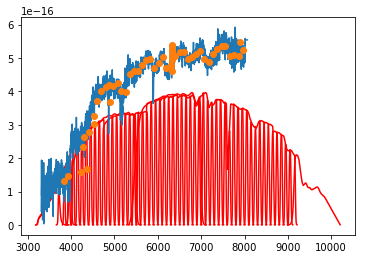

1019.52707.261.txt
('g_JPAS_0915', 1.0207373177873258)
('Jv0915_3495', 1.0927742877705375)
('Jv0915_3781', 0.88565920504973195)
('Jv0915_3900', 1.0212017974593257)
('Jv0915_4000', 1.1139150314658284)
('Jv0915_4100', 1.0698105997398937)
('Jv0915_4200', 1.1507311985059234)
('Jv0915_4301', 1.1333456662998644)
('Jv0915_4400', 1.0873538781031922)
('Jv0915_4501', 1.0908747861015569)
('Jv0915_4600', 1.023310457602904)
('Jv0915_4701', 1.1145762488666249)
('Jv0915_4801', 1.278761986271989)
('Jv0915_4900', 0.95749597947432852)
('Jv0915_5001', 1.2920186089838528)
('Jv0915_5101', 1.1328071297755384)
('Jv0915_5201', 1.0364102503931232)
('Jv0915_5300', 1.0677825932346863)
('Jv0915_5400', 1.0940601461044264)
('Jv0915_5500', 1.059875150113194)
('Jv0915_5600', 1.0713460576466767)
('Jv0915_5700', 1.0545283984728155)
('Jv0915_5799', 1.0515373977399367)
('Jv0915_5898', 1.069670946484776)
('Jv0915_5999', 1.0533691619788468)
('Jv0915_6098', 1.0512233224621867)
('Jv0915_6199', 1.0447582540909564)
('Jv0915_63

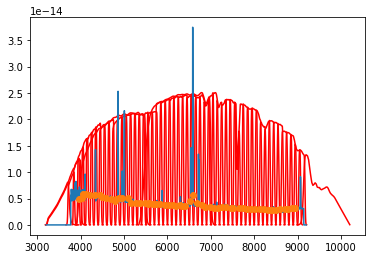

1180.52995.637.txt
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained

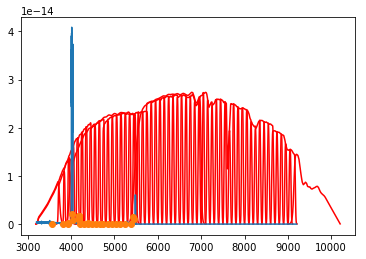

1665.52976.514_nozeroes.txt
('g_JPAS_0915', 0.88363484586562258)
('Jv0915_3495', 0.18980822552444707)
('Jv0915_3781', 0.36046609629715792)
('Jv0915_3900', 0.39648535829219284)
('Jv0915_4000', 0.72861339879876785)
('Jv0915_4100', 0.86501882326356683)
('Jv0915_4200', 0.74852588459518032)
('Jv0915_4301', 0.77734134521325626)
('Jv0915_4400', 0.85182674191097718)
('Jv0915_4501', 1.0058947770852986)
('Jv0915_4600', 0.99073443222951429)
('Jv0915_4701', 1.0955873546230217)
('Jv0915_4801', 1.0777636913502471)
('Jv0915_4900', 1.0900894858000969)
('Jv0915_5001', 1.1659071781877626)
('Jv0915_5101', 1.0568154356806998)
('Jv0915_5201', 0.93385302484216859)
('Jv0915_5300', 1.0167510411602494)
('Jv0915_5400', 1.0745753245199787)
('Jv0915_5500', 1.03921017262003)
('Jv0915_5600', 1.0469018660845872)
('Jv0915_5700', 1.021736895869364)
('Jv0915_5799', 0.99884352376362084)
('Jv0915_5898', 1.0092931312249349)
('Jv0915_5999', 1.0275389180687091)
('Jv0915_6098', 1.0621951017430509)
('Jv0915_6199', 1.080758016

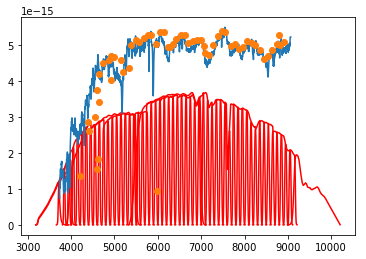

2231.53816.545.txt
('g_JPAS_0915', 0.99734036439483553)
('Jv0915_3495', 0.96275064358527696)
('Jv0915_3781', 1.0647858658666893)
('Jv0915_3900', 1.096128648098659)
('Jv0915_4000', 1.075536170352011)
('Jv0915_4100', 1.0538523360176677)
('Jv0915_4200', 1.0665906881749929)
('Jv0915_4301', 1.0653571372341175)
('Jv0915_4400', 1.0698751621547953)
('Jv0915_4501', 1.0517163463459061)
('Jv0915_4600', 1.0488628238916027)
('Jv0915_4701', 1.0348109887359194)
('Jv0915_4801', 1.0478654464985504)
('Jv0915_4900', 1.0448757402558126)
('Jv0915_5001', 1.0696664929705721)
('Jv0915_5101', 1.0468758139267478)
('Jv0915_5201', 1.0521418810303329)
('Jv0915_5300', 1.0457593728305161)
('Jv0915_5400', 1.0530070984870701)
('Jv0915_5500', 1.0413427957750976)
('Jv0915_5600', 1.0578786967009473)
('Jv0915_5700', 1.0557929410554354)
('Jv0915_5799', 1.0434006520159735)
('Jv0915_5898', 1.0484492278219457)
('Jv0915_5999', 1.0484167995862366)
('Jv0915_6098', 1.0543712312914981)
('Jv0915_6199', 1.0401242784400031)
('Jv0915_

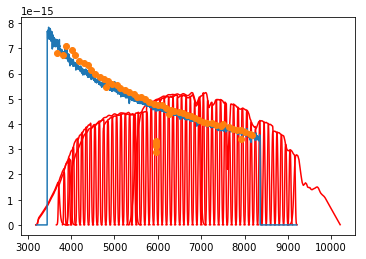

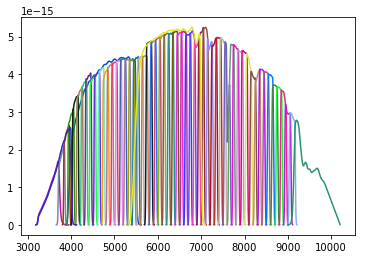

In [8]:
# JPAS -------------------------------------------------------------------------------------------------------------
all_jpas = []
for each_spectrum in specs_list:
    # Transforming the specs from f_lambda to f_nu -----------------------------------------------------------------
    wavelength = np.loadtxt(os.path.join(test_specs, each_spectrum), usecols=[0])
    f_lambda   = np.loadtxt(os.path.join(test_specs, each_spectrum), usecols=[1])
    
    # Simulating the photometry for each J-PAS band ----------------------------------------------------------------
    print each_spectrum
    filter_name     = []
    photometry      = []
    photometry_flam = []
    lambda_eff      = []
    for jpas_filters in jpas_filters_list:
        filter_name_i          = jpas_filters.split('.')[0]
        filter_name.append(filter_name_i)
        jpas_filter_bandpass = s.FileBandpass(os.path.join(jpas_filters_path, jpas_filters))      
        sdss_spectrum = s.FileSpectrum(os.path.join(test_specs, each_spectrum))
        
        # Correcting for the effects of flux = 0: ----------------------------------------------------------------------
        index = np.where(sdss_spectrum.flux > 0)
        sdss_spectrum2 = s.ArraySpectrum(wave=sdss_spectrum.wave[index], flux=sdss_spectrum.flux[index], 
                                         fluxunits=sdss_spectrum.fluxunits, waveunits=sdss_spectrum.waveunits)
        
        # Adapting the binset for each spectrum --------------------------------------------------------------------
        binset = np.arange(sdss_spectrum2.wave.min().round(), sdss_spectrum2.wave.max().round())
        
        # Calculating the simulated photometry ---------------------------------------------------------------------
        photometry_i = s.Observation(sdss_spectrum2, jpas_filter_bandpass, binset=binset, 
                                     force='extrap')
        photometry.append(photometry_i.effstim('abmag'))
        photometry_flam_i = photometry_i.effstim('flam')
        photometry_flam.append(photometry_flam_i)
        
        # Calculating the effective wavelength ---------------------------------------------------------------------
        lambda_eff_i = photometry_i.efflam()
        lambda_eff.append(lambda_eff_i)

        # Setting the filters throughput ---------------------------------------------------------------------------
        fmax = sdss_spectrum.flux.max()
        plt.plot(jpas_filter_bandpass.wave, jpas_filter_bandpass.throughput * fmax, label='%s' % each_spectrum, 
                 color='red')

    # Transforming everything into an array ------------------------------------------------------------------------
    filter_name       = np.array(filter_name)
    photometry        = np.array(photometry)
    lambda_eff        = np.array(lambda_eff) 
    photometry_flam   = np.array(photometry_flam)
    photometry_fnu    = 10**(-0.4*(photometry + 48.60))
    
    numerator_sum   = 0
    denominator_sum = 0
    ratio = []
    for j in range(lambda_eff.size):
        index = np.abs(lambda_eff[j] - wavelength).argmin()
        numerator_sum   = numerator_sum + (photometry_flam[j] * f_lambda[index])
        denominator_sum = denominator_sum + (photometry_flam[j] ** 2.)
        correction_factor = (numerator_sum / denominator_sum)
        ratio_i = photometry_flam[j]/f_lambda[index]
        ratio.append(ratio_i)
        print (filter_name[j], ratio_i)
    photometry_flam = photometry_flam * correction_factor

    
    plot01 = plt.plot(wavelength, f_lambda, '-')
    plot02 = plt.plot(lambda_eff, photometry_flam, 'o')
#     plt.savefig(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS.png'), dpi = 100)
    plt.show()
    
#     galaxy_simulation_abmag = np.vstack((filter_name, photometry))
#     galaxy_simulation_abmag = pd.DataFrame(galaxy_simulation_abmag)
#     galaxy_simulation_abmag.to_csv(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS_abmag.csv'), 
#                                    sep=',', header=None, index=False)
#     galaxy_simulation_fnu = np.vstack((filter_name, photometry_fnu))
#     galaxy_simulation_fnu = pd.DataFrame(galaxy_simulation_fnu)
#     galaxy_simulation_fnu.to_csv(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS_fnu.csv'), 
#                                  sep=',', header=None, index=False)


filter_name = []
for jpas_filters in jpas_filters_list:
    filter_name_i          = jpas_filters.split('.')[0]
    filter_name.append(filter_name_i)
    jpas_filter_bandpass = s.FileBandpass(os.path.join(jpas_filters_path, jpas_filters))
    plt.plot(jpas_filter_bandpass.wave, jpas_filter_bandpass.throughput * fmax, label='%s' % each_spectrum, 
                 color=np.random.rand(3,1))
plt.show()
    
